# Importing necessary packages, loading in data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_cars = pd.read_csv("https://raw.githubusercontent.com/NigelPetersen/UsedCars/main/raw_cars_data.csv")
raw_cars.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'price_usd', 'is_exchangeable', 'location_region',
       'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'duration_listed'],
      dtype='object')

# Data cleaning and feature engineering

In [3]:
nuissance_variables = ["engine_fuel", "up_counter", "has_warranty", "number_of_photos",
                       "engine_has_gas", "state", "is_exchangeable"]
raw_cars = raw_cars.drop(columns = nuissance_variables, axis = 1)

raw_cars = raw_cars.loc[raw_cars["price_usd"] >= 250]

In [4]:
def get_counts(my_data, variable):
    count_data = my_data.groupby([variable]).agg(
        Count = pd.NamedAgg(column = variable, aggfunc = "count")
    )
    count_data["Proportion"] = np.round(100*count_data["Count"]/len(my_data), 2)
    return count_data.sort_values(by = ["Count"], ascending = False).reset_index()

In [5]:
features = ["feature_" + str(i) for i in range(10)]
raw_cars["feature_count"] = raw_cars[features].sum(axis = 1).apply(str)
raw_cars = raw_cars.drop(columns = features, axis = 1)

regions = raw_cars["location_region"].unique()
new_regions = ["Region_" + str(i+1) for i in range(len(regions))]
raw_cars["location_region"] = raw_cars["location_region"].replace(regions, new_regions)

raw_cars["transmission"] = raw_cars["transmission"].replace(["mechanical"], ["manual"])

raw_cars["log_price"] = np.log(raw_cars["price_usd"])

manufacturer_counts = get_counts(raw_cars, "manufacturer_name")
popular_brands = manufacturer_counts.loc[manufacturer_counts["Proportion"] > 1]["manufacturer_name"]
body_type_counts = get_counts(raw_cars, "body_type")
popular_body_types = body_type_counts.loc[body_type_counts["Proportion"] > 5]["body_type"]
raw_cars = raw_cars.loc[(raw_cars["manufacturer_name"].isin(popular_brands)) &
 (raw_cars["body_type"].isin(popular_body_types)) & (raw_cars["year_produced"] >= 1990)]

color_counts = get_counts(raw_cars, "color")
other_colors = list(color_counts.loc[color_counts["Proportion"] < 5]["color"])
raw_cars["color"] = raw_cars["color"].replace(other_colors, "other")

cars_data = raw_cars.dropna().reset_index(drop = True)

<ipython-input-5-e40008a94962>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cars["color"] = raw_cars["color"].replace(other_colors, "other")


# Preliminary plots and analysis

In [6]:
sns.set(rc={'figure.figsize':(12,8)}, style = "whitegrid")

def frequency_plot(my_data, variable, labels, horizontal = True):
    if horizontal:
        my_plot = sns.barplot(x = "Count", y = variable, data = get_counts(my_data, variable))
        my_plot.set(xlabel = "Counts", ylabel = labels[0], title = labels[1])

    else:
        my_plot = sns.barplot(x = variable, y = "Count", data = get_counts(my_data, variable))
        my_plot.set(xlabel = labels[0], ylabel = "Counts", title = labels[1])
    return my_plot

def facet_frequency_plot(my_data, variable, facet_variable, labels):
    plot_data = my_data.groupby([variable, facet_variable]).agg(
        Count = pd.NamedAgg(column = variable, aggfunc = "count")
    ).sort_values(by = ["Count"], ascending = False).reset_index()

    my_plot = sns.barplot(x = "Count", y = variable, hue = facet_variable, data = plot_data)
    my_plot.set(xlabel = "Counts", ylabel = labels[0], title = labels[1])
    return my_plot

def boxplot_against_response(my_data, variable, response, labels, plot_median = True):
    my_plot = sns.boxplot(x = response, y = variable, data = my_data)
    my_plot.set(xlabel = labels[0], ylabel = labels[1], title = labels[2])
    if plot_median:
        my_plot.axvline(x = np.median(my_data[response]), color = "red", linestyle = "dashed")
    return my_plot

def facet_boxplot_against_response(my_data, variable, response, facet_variable, labels):
    plot_data = my_data.sort_values(by = [response], ascending = False)
    my_plot = sns.boxplot(x = response, y = variable, hue = facet_variable, data = plot_data)
    my_plot.set(xlabel = labels[0], ylabel = labels[1], title = labels[2])
    sns.move_legend(my_plot, "upper right")
    return my_plot

categorical_variables = ["manufacturer_name", "transmission", "color", "engine_type",
                         "body_type", "drivetrain", "location_region", "feature_count"]

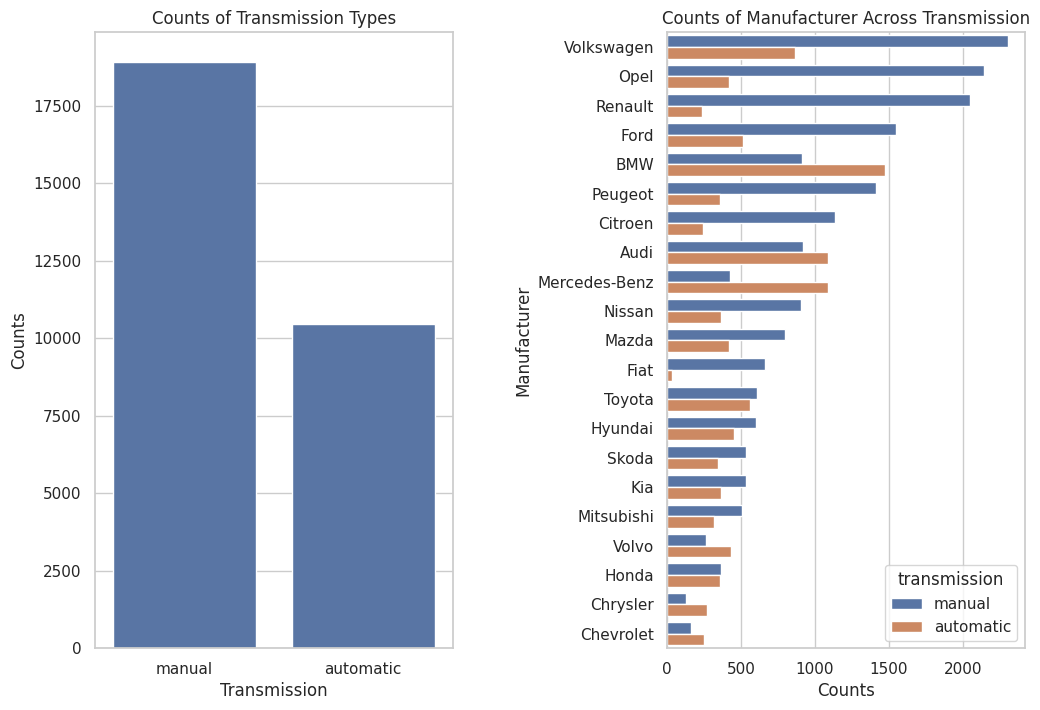

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace = 0.6)
ax = fig.add_subplot(1,2,1)
frequency_plot(cars_data, "transmission", ["Transmission", "Counts of Transmission Types"], horizontal = False)
ax = fig.add_subplot(1,2,2)
facet_frequency_plot(cars_data, "manufacturer_name", "transmission",
 ["Manufacturer", "Counts of Manufacturer Across Transmission"])
plt.show()

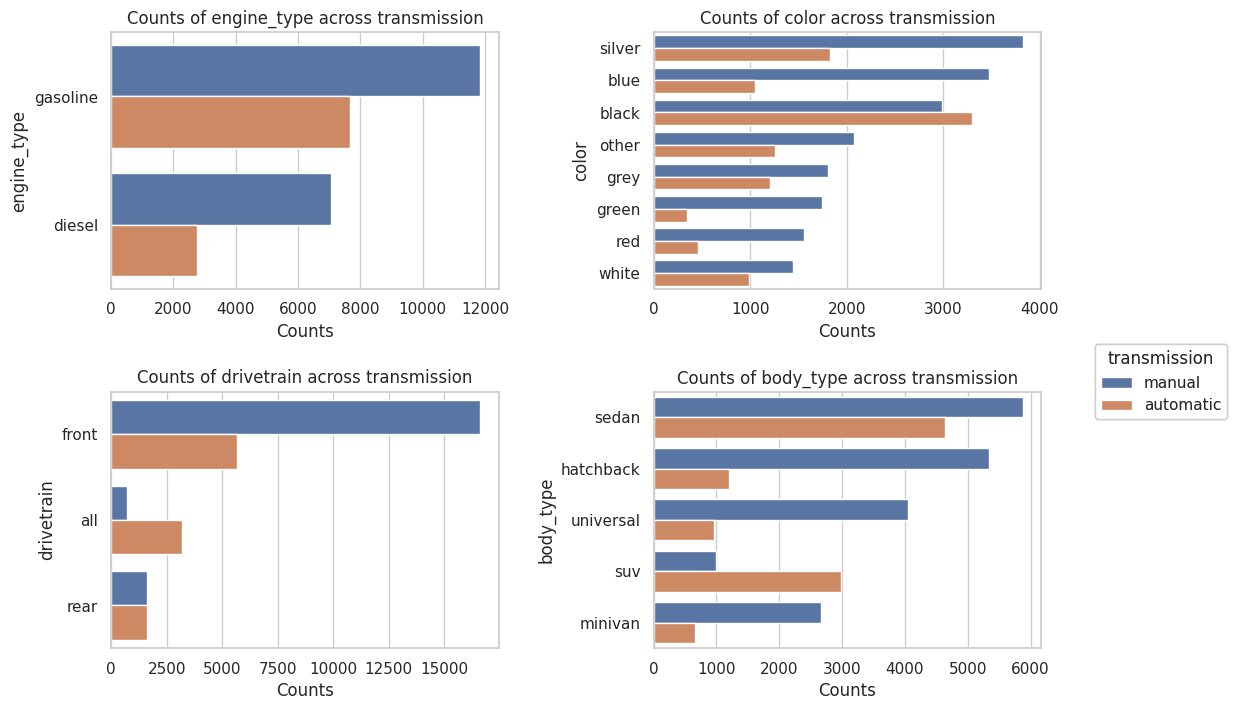

In [ ]:
plotting_variables = ["engine_type", "color", "drivetrain", "body_type"]
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)
for i in range(len(plotting_variables)):
    ax = fig.add_subplot(2,2,i+1)
    variable = plotting_variables[i]
    plot = facet_frequency_plot(cars_data, variable, "transmission",
     [variable, "Counts of " + variable + " across transmission"])
    sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

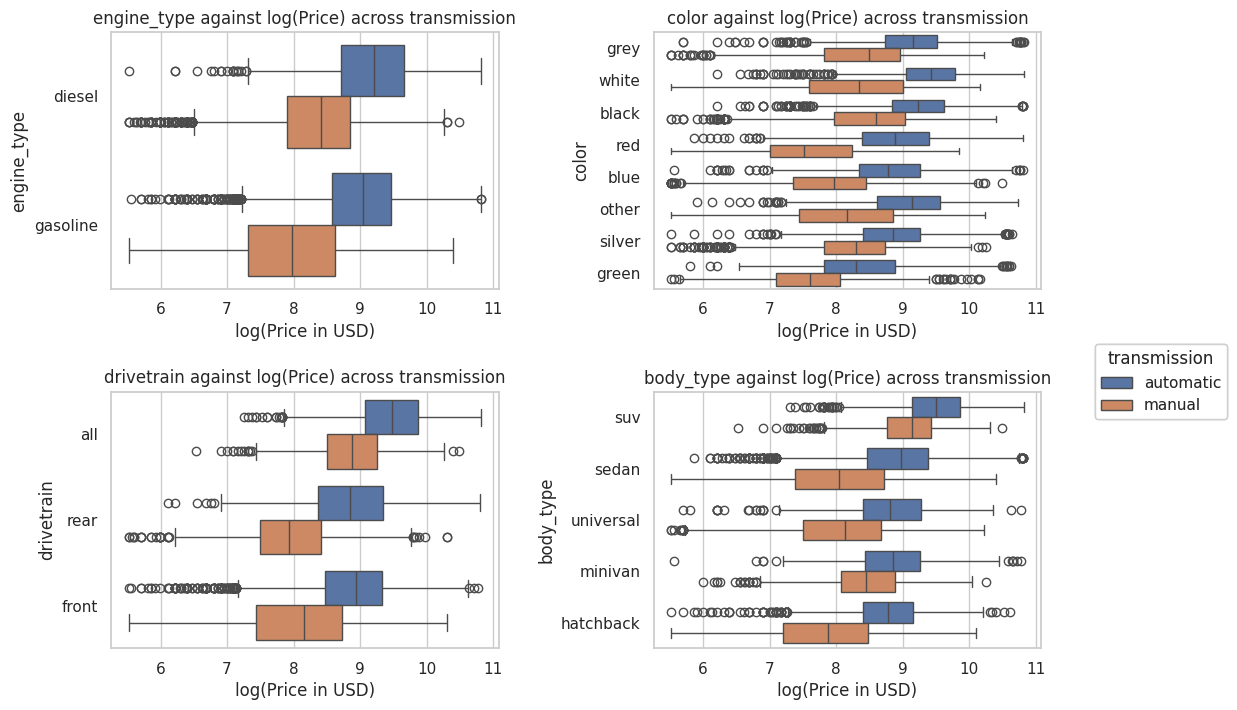

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)
for i in range(len(plotting_variables)):
    ax = fig.add_subplot(2,2,i+1)
    variable = plotting_variables[i]
    plot = facet_boxplot_against_response(cars_data, variable, "log_price", "transmission",
     ["log(Price in USD)", variable, variable + " against log(Price) across transmission"])
    sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

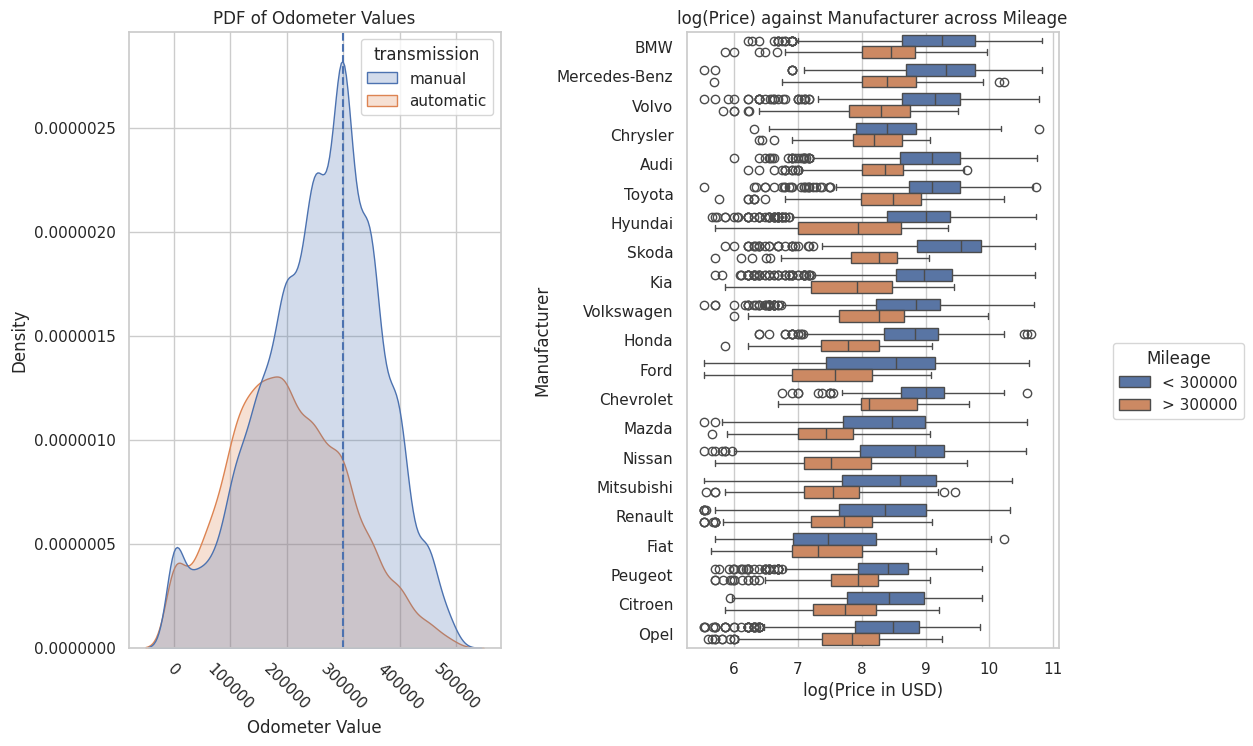

In [7]:
cars_data["Mileage"] = (cars_data["odometer_value"] > 300000).apply(str)
cars_data["Mileage"] = cars_data["Mileage"].replace(["True", "False"], ["> 300000", "< 300000"])
cars_data = cars_data.loc[cars_data["odometer_value"] < 500000]

fig = plt.figure()
fig.subplots_adjust(wspace = 0.5)
ax = fig.add_subplot(1,2,1)
density_plot = sns.kdeplot(x = "odometer_value", fill = True, hue = "transmission", data = cars_data)
density_plot.axvline(x = 300000, color = "b", linestyle = "dashed")
density_plot.set(xlabel = "Odometer Value", title = "PDF of Odometer Values")
density_plot.ticklabel_format(style = "plain")
ax.tick_params(axis = "x", rotation = -45)

ax = fig.add_subplot(1,2,2)
plot_2 = facet_boxplot_against_response(cars_data, "manufacturer_name", "log_price", "Mileage",
            ["log(Price in USD)", "Manufacturer", "log(Price) against Manufacturer across Mileage"])
sns.move_legend(plot_2, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

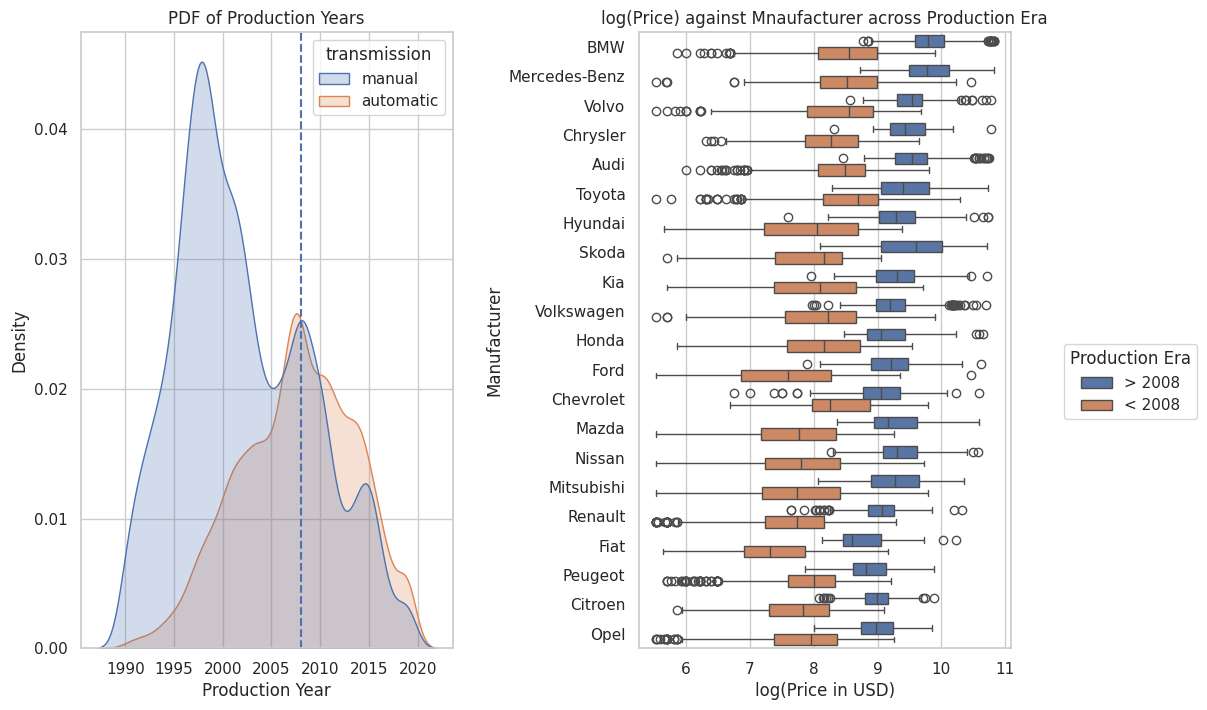

In [8]:
cars_data["Production Era"] = (cars_data["year_produced"] >= 2008).apply(str)
cars_data["Production Era"] = cars_data["Production Era"].replace(["True", "False"], ["> 2008", "< 2008"])

fig = plt.figure()
fig.subplots_adjust(wspace = 0.5)
ax = fig.add_subplot(1,2,1)
plot_1 = sns.kdeplot(x = "year_produced", fill = True, hue = "transmission", data = cars_data)
plot_1.axvline(x = 2008, color = "b", linestyle = "dashed")
plot_1.set(xlabel = "Production Year", title = "PDF of Production Years")

ax = fig.add_subplot(1,2,2)
plot_2 = facet_boxplot_against_response(cars_data, "manufacturer_name", "log_price", "Production Era",
            ["log(Price in USD)", "Manufacturer", "log(Price) against Mnaufacturer across Production Era"])
sns.move_legend(plot_2, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

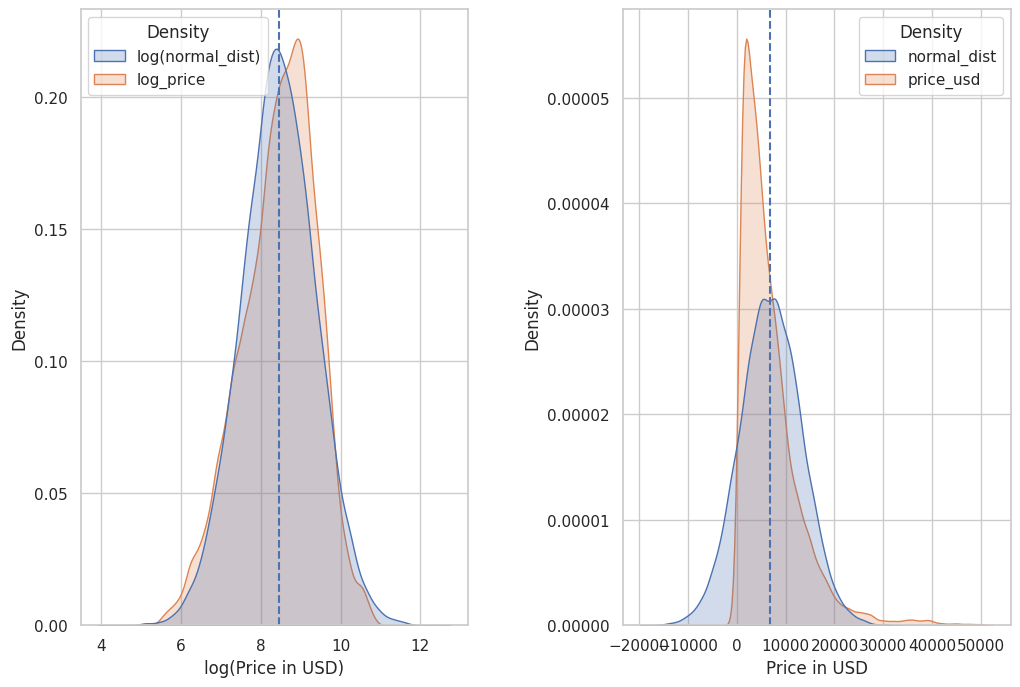

In [9]:
log_normal_dist = np.random.normal(loc = np.mean(cars_data["log_price"]),
                                   scale = np.std(cars_data["log_price"]), size = len(cars_data))
normal_dist = np.random.normal(loc = np.mean(cars_data["price_usd"]),
                               scale = np.std(cars_data["price_usd"]), size = len(cars_data))

dist_plot_data = cars_data[["log_price", "price_usd"]].copy()
dist_plot_data["log(normal_dist)"] = log_normal_dist
dist_plot_data["normal_dist"] = normal_dist

log_data = pd.melt(dist_plot_data, id_vars = ["price_usd"], value_vars = ["log(normal_dist)", "log_price"],
                   var_name = "Density", value_name = "log(Price in USD)")

normal_data = pd.melt(dist_plot_data, id_vars = ["log_price"], value_vars = ["normal_dist", "price_usd"],
                      var_name = "Density", value_name = "Price in USD")

fig = plt.figure()
fig.subplots_adjust(wspace = 0.4)
ax = fig.add_subplot(1,2,1)
plot_1 = sns.kdeplot(x = "log(Price in USD)", fill = True, hue = "Density", data = log_data)
plot_1.axvline(x = np.mean(dist_plot_data["log_price"]), color = "b", linestyle = "dashed")
sns.move_legend(plot_1, loc = "upper left")

ax = fig.add_subplot(1,2,2)
plot_2 = sns.kdeplot(x = "Price in USD", fill = True, hue = "Density", data = normal_data)
plot_2.axvline(x = np.mean(dist_plot_data["price_usd"]), color = "b", linestyle = "dashed")
plot_2.ticklabel_format(style = "plain")

# More preprocessing, model fitting

In [ ]:
cars_data.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_type', 'engine_capacity',
       'body_type', 'drivetrain', 'price_usd', 'location_region',
       'duration_listed', 'feature_count', 'log_price', 'Mileage',
       'Production Era'],
      dtype='object')

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy import stats

model_data = shuffle(cars_data.query("duration_listed < 365").drop(
    columns = ["Mileage", "Production Era", "price_usd"], axis = 1), random_state = 666)
model_data["engine_capacity"] = model_data["engine_capacity"].apply(str)
full_model_data = pd.get_dummies(model_data.drop(columns = ["log_price"], axis = 1))
log_price = model_data["log_price"]

full_model_train, full_model_test, y_train, y_test = train_test_split(full_model_data, log_price, test_size = 0.3)

In [ ]:
full_model = LinearRegression().fit(full_model_train, y_train)

In [ ]:
def diagnostic_plots(model, training_features, training_labels):

    fitted_values = model.predict(training_features)
    residuals = fitted_values - training_labels
    std_residuals = np.array((residuals - np.mean(residuals))/np.std(residuals))
    observed_quantiles = np.sort(std_residuals)
    theoretical_quantiles = np.sort(np.random.default_rng().standard_normal(len(training_features)))

    fig = plt.figure()
    fig.subplots_adjust(wspace = 0.4)
    ax = fig.add_subplot(1,2,1)
    resid_plot = sns.scatterplot(x = fitted_values, y = std_residuals)
    resid_plot.axhline(y = 0, color = "red", linestyle = "dashed")
    resid_plot.set(xlabel = "Fitted Values",
                   ylabel = "Standardized Residuals",
                   title = "Residual Plot")

    ax = fig.add_subplot(1,2,2)
    qq_plot = sns.scatterplot(x = theoretical_quantiles, y = observed_quantiles)
    qq_plot.set(xlabel = "Theoretical Quantiles",
                ylabel = "Observed Quantiles",
                title = "Quantile Plot")
    plt.plot([-4,4], [-4,4], color = "red", linestyle = "dashed")
    fig.suptitle("Regression Diagnostic Plots")


def display_coef(model, training_features, training_labels):
    model_coefs = np.append(model.intercept_, model.coef_)
    fitted_values = model.predict(training_features)
    residuals = np.array(fitted_values - training_labels)
    X = np.append(np.ones((len(training_labels), 1)), np.array(training_features), axis = 1)
    MSE = sum(residuals**2)/(X.shape[0] - X.shape[1])
    variances = MSE*((np.linalg.inv(np.dot(X.T, X))).diagonal())
    t_values = model_coefs/np.sqrt(variances)
    p_values =[2*(1 - stats.t.cdf(np.abs(i), (X.shape[0] - X.shape[1]))) for i in t_values]

    summary_df = pd.DataFrame()
    summary_df["Coefficient"] = ["Intercept"] + list(training_features.columns)
    summary_df["Estimate"] = np.round(model_coefs, 4)
    summary_df["Standard Error"] = np.round(variances, 4)
    summary_df["t value"] = np.round(t_values, 4)
    summary_df["Pr( >|t|)"] = np.round(p_values, 4)

    return summary_df

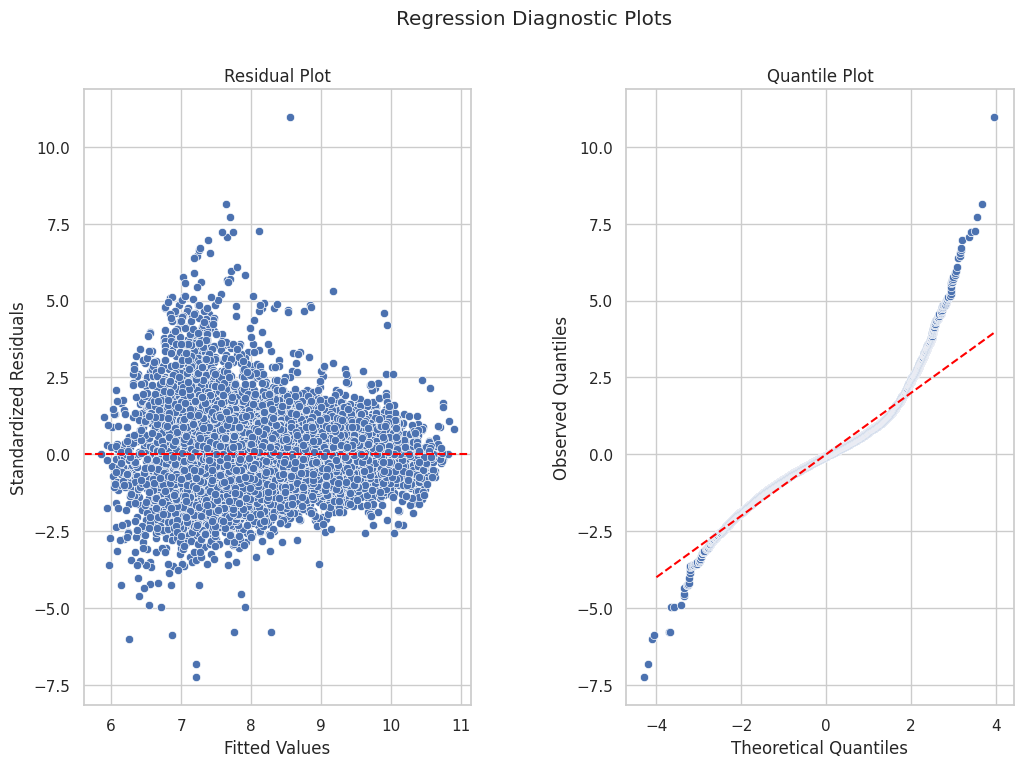

In [ ]:
diagnostic_plots(full_model, full_model_train, y_train)
plt.show()